# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from get_hdma_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


## 2. Configuration

In [2]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.255       # Binary Label Noise probability
#disc_factor = np.pi/2     # Similarity of Y_sen to X
#n_samples = 2000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                 # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd = 0.5                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= -2
lmd_end= 12
lmd_interval = np.linspace(lmd_start, lmd_end, 40)
symmetric_fairness = False

## 3. Data Generation

In [4]:
X, Y, Y_sen = get_hdma_data(0.1, True, True)
Y_corrupted = add_sym_noise(Y, flip_prob, rnd_seed)
Y_sen_corrupted = add_sym_noise(Y_sen, 0.0, rnd_seed) ##We don't need to extra corrupt the sensitive attribute, since we assume only Y is being corrupted. because we already corrupted the input.

/home/ptr@itd.local/code/fairness_triangle/tools/get_hdma_data.py:13: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pd.read_csv("../datasets/2024_public_lar.csv", skiprows=lambda i: i > 0 and random.random() > perc_original)


## 4. Model Training

In [5]:
X

,activity_year,derived_msa_md,census_tract,conforming_loan_limit,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,...,loan_product_type_FSA/RHS:First Lien,loan_product_type_FSA/RHS:Subordinate Lien,loan_product_type_VA:First Lien,derived_ethnicity_Hispanic or Latino,derived_ethnicity_Joint,derived_ethnicity_Not Hispanic or Latino,derived_sex_Joint,derived_sex_Male,dwelling_category_Single Family (1-4 Units):Manufactured,dwelling_category_Single Family (1-4 Units):Site-Built
0,2024,41304,1.210303e+10,1,71,2,1,1,1,2,...,False,False,False,False,False,True,False,True,False,True
1,2024,40900,6.017031e+09,1,0,2,1,1,1,2,...,False,False,False,False,False,True,True,False,False,True
2,2024,35084,3.403903e+10,1,0,2,1,2,2,2,...,False,False,False,False,False,True,True,False,False,True
3,2024,44700,6.077005e+09,1,0,1,1,1,1,2,...,False,False,False,False,False,True,True,False,False,True
4,2024,11244,6.059032e+09,1,0,2,1,2,1,2,...,False,False,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11481,2024,31700,3.301100e+10,1,71,2,1,32,1,2,...,False,False,False,False,False,True,False,False,False,True
11482,2024,29540,4.207101e+10,1,0,2,1,2,2,2,...,False,False,False,False,False,True,True,False,False,True
11483,2024,23104,4.843911e+10,1,2,2,3,1,1,2,...,False,False,True,False,False,True,True,False,False,True
11484,2024,24540,8.123002e+09,1,0,2,2,1,1,2,...,False,False,False,False,False,True,True,False,False,True


In [6]:
# Split data
split_index = int(split_ratio * len(X))
X_train, X_test =                       X[:split_index],            X[split_index:]
Y_train, Y_test =                       Y[:split_index],            Y[split_index:]
Y_train_corrupted, Y_test_corrupted =   Y_corrupted[:split_index],  Y_corrupted[split_index:]
Y_sen_train, Y_sen_test =               Y_sen[:split_index],        Y_sen[split_index:]
Y_sen_train_corrupted, Y_sen_test_corrupted = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]

# Initialize and train models
p_reg = LogisticRegression().fit(X_train, Y_train)
p_reg_cor = LogisticRegression().fit(X_train, Y_train_corrupted)
f_reg = LogisticRegression().fit(X_train, Y_sen_train)
f_reg_cor = LogisticRegression().fit(X_train, Y_sen_train_corrupted)

In [7]:
from sklearn.metrics import accuracy_score

# Predictions
y_pred_p_reg = p_reg.predict(X_test)
y_pred_p_reg_cor = p_reg_cor.predict(X_test)
y_pred_f_reg = f_reg.predict(X_test)
y_pred_f_reg_cor = f_reg_cor.predict(X_test)

# Accuracy calculations
acc_p_reg = accuracy_score(Y_test, y_pred_p_reg)
acc_p_reg_cor = accuracy_score(Y_test, y_pred_p_reg_cor)
acc_f_reg = accuracy_score(Y_sen_test, y_pred_f_reg)
acc_f_reg_cor = accuracy_score(Y_sen_test, y_pred_f_reg_cor)

# Print results
print(f"Accuracy (p_reg): {acc_p_reg:.4f}")
print(f"Accuracy (p_reg_cor): {acc_p_reg_cor:.4f}")
print(f"Accuracy (f_reg): {acc_f_reg:.4f}")
print(f"Accuracy (f_reg_cor): {acc_f_reg_cor:.4f}")

Accuracy (p_reg): 0.5038
Accuracy (p_reg_cor): 0.4962
Accuracy (f_reg): 0.4852
Accuracy (f_reg_cor): 0.4852


In [8]:
pct_Y_train = (Y_train == 1).mean() * 100
pct_Y_test = (Y_test == 1).mean() * 100
pct_Y_sen = (Y_sen_test == 1).mean() * 100

print(f"Y_train {pct_Y_train:.2f}% are 1")
print(f"Y_test: {pct_Y_test:.2f}% are 1")
print(f"Y_sen_test: {pct_Y_sen:.2f}% are 1")

Y_train 50.50% are 1
Y_test: 50.38% are 1
Y_sen_test: 51.48% are 1


In [ ]:
columns_to_scale =['derived_msa_md']

In [23]:
def un(name):
    print(X[name].unique())
    
un("loan_purpose")

[ 1  2  4 32 31]


In [11]:
# Show dtypes for all non-bool columns
print(X.dtypes[X.dtypes != 'bool'])


activity_year                                 int64
derived_msa_md                                int64
census_tract                                float64
conforming_loan_limit                         int64
purchaser_type                                int64
preapproval                                   int64
loan_type                                     int64
loan_purpose                                  int64
lien_status                                   int64
reverse_mortgage                              int64
open_end_line_of_credit                       int64
business_or_commercial_purpose                int64
loan_amount                                   int64
combined_loan_to_value_ratio                float64
interest_rate                               float64
hoepa_status                                  int64
loan_term                                     int64
negative_amortization                         int64
interest_only_payment                         int64
balloon_paym

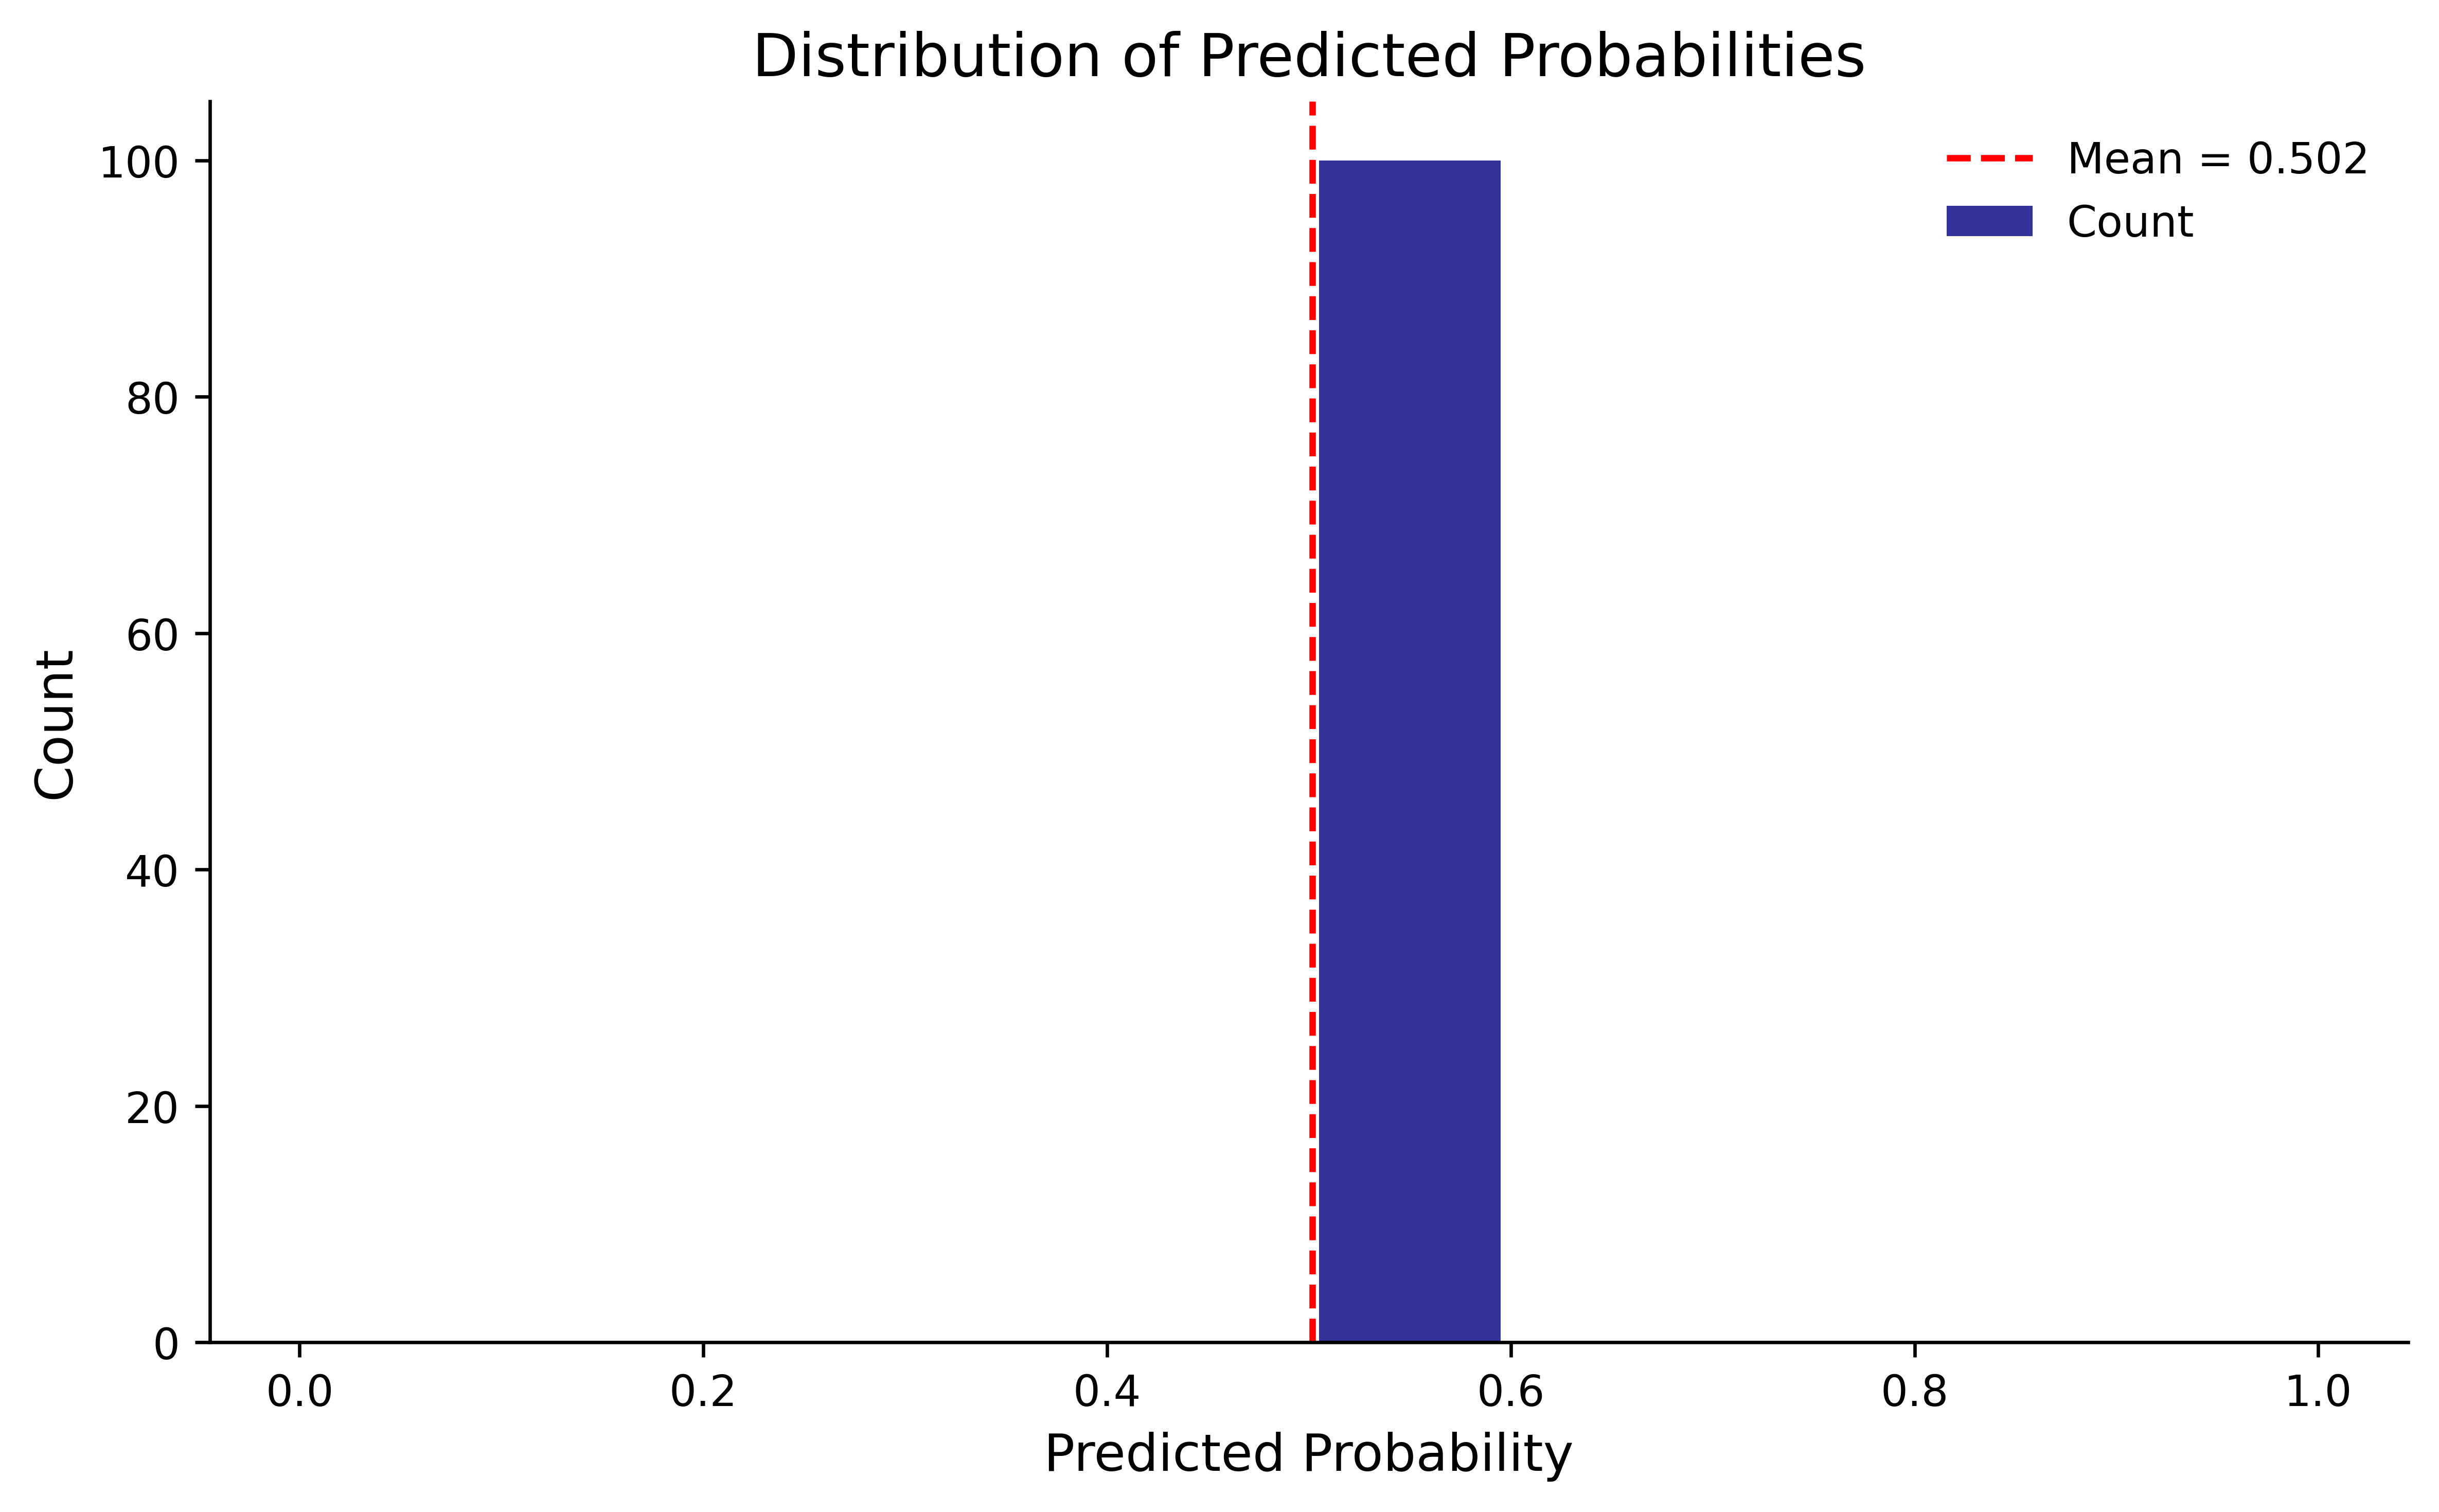

In [9]:
arr = p_reg.predict_proba(X_test[:100])[:, 1]
mean_val = arr.mean()

# Define bins
bins = np.arange(0, 1.1, 0.1)  # 0 to 1 in steps of 0.1

# Histogram
counts, edges = np.histogram(arr, bins=bins)

# Midpoints for plotting
bin_centers = (edges[:-1] + edges[1:]) / 2

# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(bin_centers, counts, width=0.09, color='navy', alpha=0.8, label='Count')
ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean = {mean_val:.3f}')

ax.set_xlabel("Predicted Probability", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of Predicted Probabilities", fontsize=14)

ax.legend(frameon=False, fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import recall_score
# Calculate 's' for each lambda
s = p_reg.predict_proba(X_test)[:, 1] - c - 0 * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

# Apply step function H_a(z) with a = 0
Y_pred = pd.Series(np.where(s > 0, 1, 0), index=Y_test.index)
BER = calc_BER(Y_pred, Y_test)
MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
print(BER,MD,DI)

TP, TN, FP, FN, FPR, FNR = calc_confusion_matrix(Y_pred, Y_test)
print(FPR, FNR)

tpr = recall_score(Y_test, Y_pred, pos_label=1)  # sensitivity
tnr = recall_score(Y_test, Y_pred, pos_label=0)  # specificity
ber_sklearn = 1 - (tpr + tnr) / 2

print("BER (sklearn) =", ber_sklearn)


0.5 0.0 1.0
1.0 0.0
BER (sklearn) = 0.5


In [8]:
Y_pred.sum()

3407

## 5. Finetuning cost Parameters c and c_bar

In [9]:
"""
# ---------- Example usage over your lmd_interval ----------
# Pick your grids (finer grid => more precise but slower)
c_grid = np.linspace(0.0, 1.0, 101)
cbar_grid = np.linspace(0.0, 1.0, 101)

results = []
for lmd in lmd_interval:
    c_opt, cbar_opt, ber_opt, md_opt = tune_c_and_cbar_separately(
        p_reg=p_reg,
        f_reg=f_reg,
        X_val=X_val,
        Y_val=Y_val,
        Y_sen_val=Y_sen_val,
        lmd=lmd,
        symmetric_fairness=symmetric_fairness,
        c_grid=c_grid,
        cbar_grid=cbar_grid,
        init_c=0.5,
        init_cbar=0.5,
        max_iters=3   # usually enough; raise if you want
    )
    results.append({
        "lambda": lmd,
        "c": c_opt,
        "c_bar": cbar_opt,
        "BER_val": ber_opt,
        "MD_val": md_opt
    })

results
"""

'\n# ---------- Example usage over your lmd_interval ----------\n# Pick your grids (finer grid => more precise but slower)\nc_grid = np.linspace(0.0, 1.0, 101)\ncbar_grid = np.linspace(0.0, 1.0, 101)\n\nresults = []\nfor lmd in lmd_interval:\n    c_opt, cbar_opt, ber_opt, md_opt = tune_c_and_cbar_separately(\n        p_reg=p_reg,\n        f_reg=f_reg,\n        X_val=X_val,\n        Y_val=Y_val,\n        Y_sen_val=Y_sen_val,\n        lmd=lmd,\n        symmetric_fairness=symmetric_fairness,\n        c_grid=c_grid,\n        cbar_grid=cbar_grid,\n        init_c=0.5,\n        init_cbar=0.5,\n        max_iters=3   # usually enough; raise if you want\n    )\n    results.append({\n        "lambda": lmd,\n        "c": c_opt,\n        "c_bar": cbar_opt,\n        "BER_val": ber_opt,\n        "MD_val": md_opt\n    })\n\nresults\n'

## 6. Metric Calculation: BER and Fairness

In [10]:
# Sweep over lambda values and calculate metrics
BER_list = []
MD_list = []
DI_list = []
BER_list_corr = []
MD_list_corr = []
DI_list_corr = []

# lmd = how important is fairness
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)
    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, symmetric_fairness)
    DI = calc_DI(Y_pred, Y_sen_test, symmetric_fairness)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)


# Compute now with Corrupted labels
for lmd in lmd_interval:
    # Calculate 's' for each lambda
    s_2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg_cor.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred_2 = np.where(s_2 > 0, 1, 0)

    BER_2 = calc_BER(Y_pred_2, Y_test)
    MD_2 = calc_MD(Y_pred_2, Y_sen_test, symmetric_fairness)
    DI_2 = calc_DI(Y_pred_2, Y_sen_test, symmetric_fairness)
    
    BER_list_corr.append(BER_2)
    MD_list_corr.append(MD_2)
    DI_list_corr.append(DI_2)

In [11]:
# Store results in DataFrame
results = pd.DataFrame({
    'lambda': lmd_interval,
    'BER_clean': BER_list,
    'MD_clean': MD_list,
    'DI_clean': DI_list,
    'BER_corr': BER_list_corr,
    'MD_corr': MD_list_corr,
    'DI_corr': DI_list_corr
})

In [12]:
results

,lambda,BER_clean,MD_clean,DI_clean,BER_corr,MD_corr,DI_corr
0,-2.000000,0.5,0.0,0.0,0.5,0.0,0.0
1,-1.641026,0.5,0.0,0.0,0.5,0.0,0.0
2,-1.282051,0.5,0.0,0.0,0.5,0.0,0.0
3,-0.923077,0.5,0.0,0.0,0.5,0.0,0.0
4,-0.564103,0.5,0.0,0.0,0.5,0.0,0.0
5,-0.205128,0.5,0.0,1.0,0.5,0.0,1.0
6,0.153846,0.5,0.0,1.0,0.5,0.0,1.0
7,0.512821,0.5,0.0,1.0,0.5,0.0,1.0
8,0.871795,0.5,0.0,1.0,0.5,0.0,1.0
9,1.230769,0.5,0.0,1.0,0.5,0.0,1.0


/tmp/ipykernel_430384/2668734600.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_430384/2668734600.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


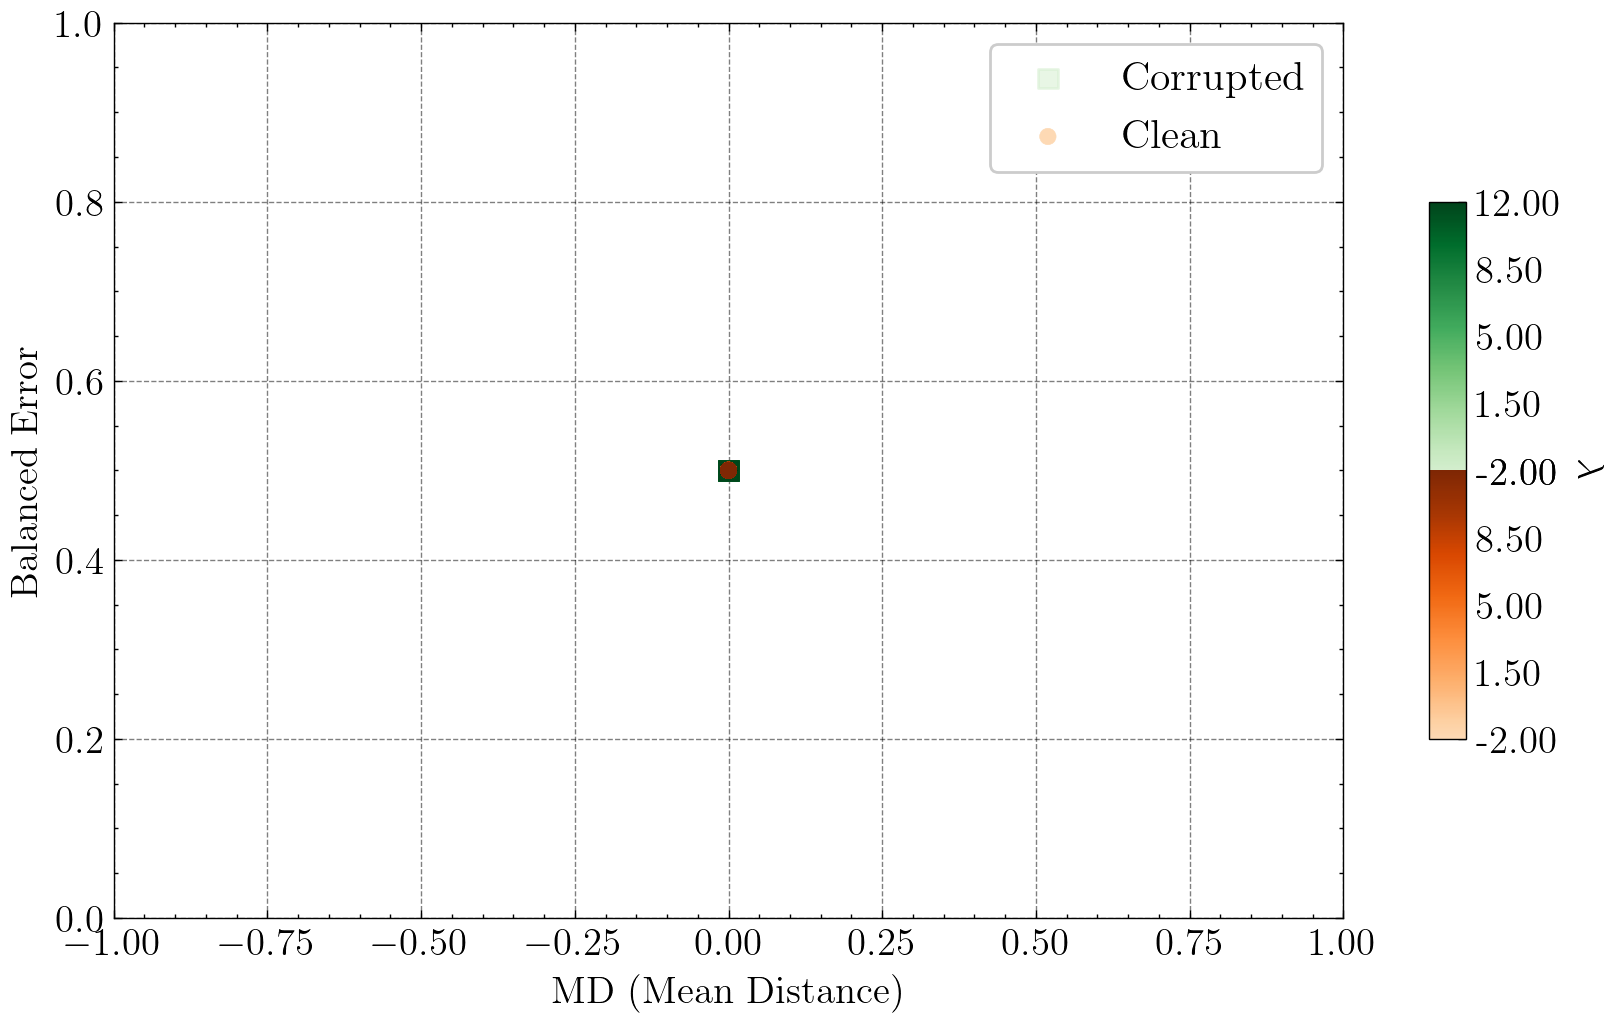

In [13]:
fig = science_fig()
ax = fig.gca()
df = results
df_sorted = df.sort_values(by="lambda")
# Normalize lambda between 0 and 1 for darkness control
lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())

# Truncate colormaps to avoid bright near-white colors
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
green_cmap = truncate_colormap('Greens', 0.2, 1.0)

ax.plot(df_sorted["MD_clean"], df_sorted["BER_clean"],
        color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

# Connect Corrupted data points with a line
ax.plot(df_sorted["MD_corr"], df_sorted["BER_corr"],
        color="forestgreen", linestyle='-', linewidth=1, label="_nolegend_")
# Plot Clean data with orange shades
sc2 = ax.scatter(df["MD_corr"], df["BER_corr"], c=lambda_norm, cmap=green_cmap, label="Corrupted", s=50,marker="s",  alpha=0.5)
sc1 = ax.scatter(df["MD_clean"], df["BER_clean"], c=lambda_norm, cmap=orange_cmap, label="Clean", linewidths= 0.2, s=35)
# Plot Corrupted data


# Create combined colormap by stacking half-orange and half-green
n = 256
orange_colors = orange_cmap(np.linspace(0, 1, n))
green_colors = green_cmap(np.linspace(0, 1, n))
combined_colors = np.vstack((orange_colors, green_colors))
combined_cmap = ListedColormap(combined_colors)

# Dummy image to attach the colorbar to
sm = ax.imshow([np.linspace(0, 1, 2*n)], aspect='auto', cmap=combined_cmap, visible=False)

# Inset axes for compact colorbar (place right next to plot)
cax = inset_axes(ax,
                 width="3%",  # narrow
                 height="60%",  # shorter
                 loc='center right',
                 bbox_to_anchor=(0.1, 0, 1, 1),  # tweak position
                 bbox_transform=ax.transAxes,
                 borderpad=0)


cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)
# Set custom ticks on the colorbar to reflect actual λ values
# Tick positions for each half
ticks_orange = np.linspace(0, 0.5, 5)
ticks_green = np.linspace(0.5, 1.0, 5)

# Map λ values to each range
lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()
ticklabels_orange = np.round(np.linspace(lambda_min, lambda_max, 5), 2)
ticklabels_green = np.round(np.linspace(lambda_min, lambda_max, 5), 2)

# Combine
all_ticks = np.concatenate([ticks_orange, ticks_green])
all_ticklabels = [f"{val:.2f}" for val in ticklabels_orange] + [f"{val:.2f}" for val in ticklabels_green]

# Apply to colorbar
cbar.set_ticks(all_ticks)
cbar.set_ticklabels(all_ticklabels)

# Labels and formatting
ax.set_xlabel("MD (Mean Distance)")
ax.set_ylabel("Balanced Error")
ax.set_xlim(-0.4, 0.05)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.legend()

# Save or show
fig.tight_layout()
#fig.savefig("my_science_figure.png")
fig.show()

/tmp/ipykernel_430384/2688118335.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_430384/2688118335.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


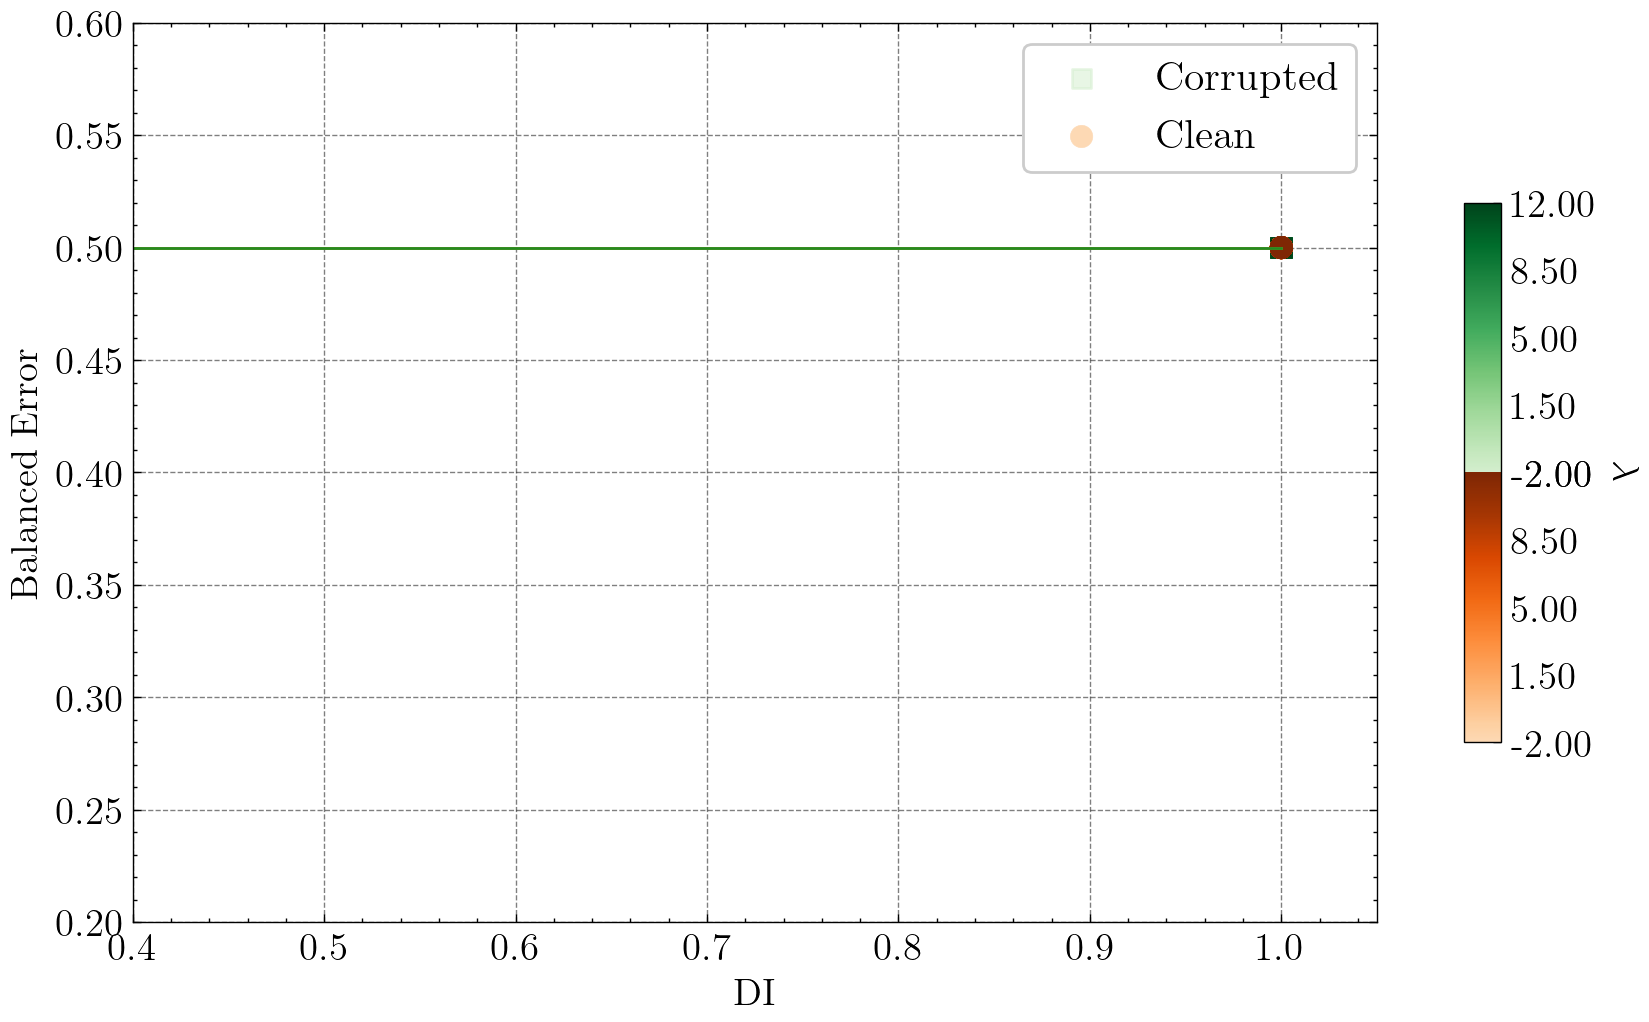

In [14]:
fig = science_fig()
ax = fig.gca()
df = results
df_sorted = df.sort_values(by="lambda")
# Normalize lambda between 0 and 1 for darkness control
lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())

# Truncate colormaps to avoid bright near-white colors
orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
green_cmap = truncate_colormap('Greens', 0.2, 1.0)

ax.plot(df_sorted["DI_clean"], df_sorted["BER_clean"],
        color="darkorange", linestyle='-', linewidth=1, label="_nolegend_")

# Connect Corrupted data points with a line
ax.plot(df_sorted["DI_corr"], df_sorted["BER_corr"],
        color="forestgreen", linestyle='-', linewidth=1, label="_nolegend_")
# Plot Clean data with orange shades
sc2 = ax.scatter(df["DI_corr"], df["BER_corr"], c=lambda_norm, cmap=green_cmap, label="Corrupted", s=50,marker="s",  alpha=0.5)
sc1 = ax.scatter(df["DI_clean"], df["BER_clean"], c=lambda_norm, cmap=orange_cmap, label="Clean", linewidths= 0.2, s=65)
# Plot Corrupted data



# Create combined colormap by stacking half-orange and half-green
n = 256
orange_colors = orange_cmap(np.linspace(0, 1, n))
green_colors = green_cmap(np.linspace(0, 1, n))
combined_colors = np.vstack((orange_colors, green_colors))
combined_cmap = ListedColormap(combined_colors)

# Dummy image to attach the colorbar to
sm = ax.imshow([np.linspace(0, 1, 2*n)], aspect='auto', cmap=combined_cmap, visible=False)

# Inset axes for compact colorbar (place right next to plot)
cax = inset_axes(ax,
                 width="3%",  # narrow
                 height="60%",  # shorter
                 loc='center right',
                 bbox_to_anchor=(0.1, 0, 1, 1),  # tweak position
                 bbox_transform=ax.transAxes,
                 borderpad=0)




cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(r"$\lambda$", rotation=270, labelpad=15)
# Set custom ticks on the colorbar to reflect actual λ values
# Tick positions for each half
ticks_orange = np.linspace(0, 0.5, 5)
ticks_green = np.linspace(0.5, 1.0, 5)

# Map λ values to each range
lambda_min, lambda_max = df["lambda"].min(), df["lambda"].max()
ticklabels_orange = np.round(np.linspace(lambda_min, lambda_max, 5), 2)
ticklabels_green = np.round(np.linspace(lambda_min, lambda_max, 5), 2)

# Combine
all_ticks = np.concatenate([ticks_orange, ticks_green])
all_ticklabels = [f"{val:.2f}" for val in ticklabels_orange] + [f"{val:.2f}" for val in ticklabels_green]

# Apply to colorbar
cbar.set_ticks(all_ticks)
cbar.set_ticklabels(all_ticklabels)

# Labels and formatting
ax.set_xlabel("DI" )
ax.set_ylabel("Balanced Error")
ax.set_xlim(0.4, 1.05)
ax.set_ylim(0.2, 0.6)
ax.legend()

# Save or show
fig.tight_layout()
#fig.savefig("my_science_figure.png")
fig.show()

## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
